In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torchsummary import summary
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler

import os
import cv2
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

In [ ]:
!apt -y install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
plt.rcParams.update(plt.rcParamsDefault)

plt.matplotlib.rc('figure', figsize=(10, 6))
plt.matplotlib.rc('grid', linestyle = 'dotted', linewidth=1.5, alpha = 0.25)
plt.matplotlib.rc('text', usetex=True)
plt.matplotlib.rc('font', family='serif', size=15)
plt.matplotlib.rc('legend', fontsize=15)

# Change ticks
plt.rcParams['xtick.major.size'] = 7.0
plt.rcParams['xtick.minor.size'] = 4.0
plt.rcParams['xtick.direction'] = 'inout'
plt.rcParams['ytick.major.size'] = 7.0
plt.rcParams['ytick.minor.size'] = 4.0
plt.rcParams['ytick.direction'] = 'inout'

In [3]:
# device - cpu or gpu?
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    
# create a folder to save the model
if not os.path.isdir('CHECKPOINTS'):
    os.mkdir('CHECKPOINTS')
    
    
def elapsed_time(start_time):
    # source: https://stackoverflow.com/a/27780763
    hours, rem = divmod(time.time() - start_time, 3600)
    minutes, seconds = divmod(rem, 60)
    duration = "{:0>2}:{:0>2}:{:02d}".format(int(hours), int(minutes), int(seconds))
    return duration

In [4]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return self.labels.shape[0]
    
    def __getitem__(self, idx):
        prediction = torch.tensor(self.features[idx])
        true_value = torch.tensor(self.labels[idx])
        return prediction, true_value
    
    
def get_dataloader(features, labels, batch_size, num_workers=1):
    dataset = CustomDataset(features, labels)
    
    loader_settings = {
        'dataset': dataset,
        'batch_size': batch_size,
        'shuffle': True,
        'num_workers': num_workers,
        'pin_memory': torch.cuda.is_available()
    }
    
    return DataLoader(**loader_settings)

In [5]:
def performance_metrics(model, dataloader):
    predictions, true_labels = [], []
    with torch.no_grad():
        for data in tqdm(dataloader, leave=False):
            features, labels = data

            features = features.to(device).float()
            labels   = labels.to(device).float()

            y_pred = model(features)
            y_true = labels

            predictions += list((y_pred > 0.5).to(torch.int32).squeeze().cpu().numpy())
            true_labels += list(y_true.squeeze().to(torch.int32).cpu().numpy())

    N = len(true_labels)

    true = np.array(predictions) == np.array(true_labels)
    false = np.array(predictions) != np.array(true_labels)
    positive = np.array(predictions) > 0.5
    negative = np.array(predictions) < 0.5

    tn = 100 * np.sum(true * negative) / N
    tp = 100 * np.sum(true * positive) / N
    fn = 100 * np.sum(false * negative) / N
    fp = 100 * np.sum(false * positive) / N
    accuracy = np.sum(true) / N
    
    return tn, tp, fn, fp, accuracy

In [6]:
batch_size = 128

# load ViT features
path = '/content/drive/MyDrive/Colab Notebooks/Technion_046211-Deep_Learning'
train_features_vit = pd.read_csv(f'{path}/train_predictions.csv', header=None).to_numpy()
train_labels_vit = pd.read_csv(f'{path}/train_true_values.csv', header=None).to_numpy()
val_features_vit = pd.read_csv(f'{path}/val_predictions.csv', header=None).to_numpy()
val_labels_vit = pd.read_csv(f'{path}/val_true_values.csv', header=None).to_numpy()
train_dataloader_vit = get_dataloader(train_features_vit, train_labels_vit, batch_size)
val_dataloader_vit = get_dataloader(val_features_vit, val_labels_vit, batch_size)

# load VGG features
train_features_vgg = pd.read_csv(f'{path}/train_predictions_vgg.csv', header=None).to_numpy()
train_labels_vgg = pd.read_csv(f'{path}/train_true_values_vgg.csv', header=None).to_numpy()
val_features_vgg = pd.read_csv(f'{path}/val_predictions_vgg.csv', header=None).to_numpy()
val_labels_vgg = pd.read_csv(f'{path}/val_true_values_vgg.csv', header=None).to_numpy()
train_dataloader_vgg = get_dataloader(train_features_vgg, train_labels_vgg, batch_size)
val_dataloader_vgg = get_dataloader(val_features_vgg, val_labels_vgg, batch_size)

In [11]:
selected_model = 'vit'

############################################################
#                      DataLoader
############################################################

if selected_model == 'vgg':
    train_dataloader = train_dataloader_vgg
    val_dataloader = val_dataloader_vgg
if selected_model == 'vit':
    train_dataloader = train_dataloader_vit
    val_dataloader = val_dataloader_vit

############################################################
#                         Model
############################################################

if selected_model == 'vgg':
    dim_in = 4096
if selected_model == 'vit':
    dim_in = 768

model = nn.Sequential(
    nn.Linear(dim_in, 8192),
    nn.ReLU(),
    nn.Linear(8192, 4096),
    nn.ReLU(),
    nn.Linear(4096, 2048),
    nn.ReLU(),
    nn.Linear(2048, 1),
    nn.Sigmoid()
)

model = model.to(device)

############################################################
#                      Hyperparametrs
############################################################
epochs = 10
learning_rate = 1e-5

# select loss
criterion = nn.BCELoss()

# select optimizer
# optimizer = torch.optim.Adam(
#     params=model.parameters(),
#     lr=learning_rate,
#     amsgrad=True
# )
optimizer = torch.optim.SGD(model.parameters(), lr=1e-5)

# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=2)
scheduler = optim.lr_scheduler.CyclicLR(
    optimizer, base_lr=5e-4, max_lr=1e-2, step_size_up=2, mode="triangular2"
)

In [ ]:

start_time = time.time()
epochs_log = []
model.train()

for epoch in range(1, epochs+1):
    running_loss = 0.0
    epoch_time = time.time()

    with tqdm(train_dataloader, unit="batch", leave=False) as tepoch:
        for features, labels in tepoch:
            tepoch.set_description(f"{elapsed_time(start_time)} | Epoch {epoch:02d}/{epochs}")
            
            features = features.to(device).float()
            labels = labels.to(device).squeeze().float()
            
            pred = model(features).squeeze()         # forward pass
            loss = criterion(pred, labels)           # calculate the loss   
            optimizer.zero_grad()                    # zero the parameter gradients
            loss.backward()                          # backpropagation
            optimizer.step()                         # update parameters
            
            running_loss += loss.data.item()
        
        # update learning rate
        curr_lr = scheduler.get_last_lr()
        scheduler.step()                         
        
        # calculate loss and accuracy
        running_loss /= len(train_dataloader)
        tn, tp, fn, fp, accuracy = performance_metrics(model, val_dataloader)
        

        # show results to tqdm
        tepoch.refresh()
        tepoch.set_description(f"{elapsed_time(start_time)} | Epoch {epoch:02d}/{epochs}")
        
        if epoch == 1:
            print('         |       |               |        |                 Validation               ')
            print('  Time   | Epoch | learning rate |  Loss  | accuracy    tp      tn      fp      fn   ')
            print('---------|-------|---------------|--------|------------------------------------------')

        epoch_results = [
            f'{elapsed_time(start_time)}',
            f'{epoch:02d}/{epochs:02d}',
            f'   {curr_lr[0]:.1e}   ',
            f'{running_loss:.4f}',
            f' {100*accuracy:.02f}%    {tp:2.01f}%   {tn:.01f}%   {fp:.01f}%   {fn:.01f}%'
        ]

        epochs_log.append(epoch_results)
        print(*epoch_results, sep=' | ')

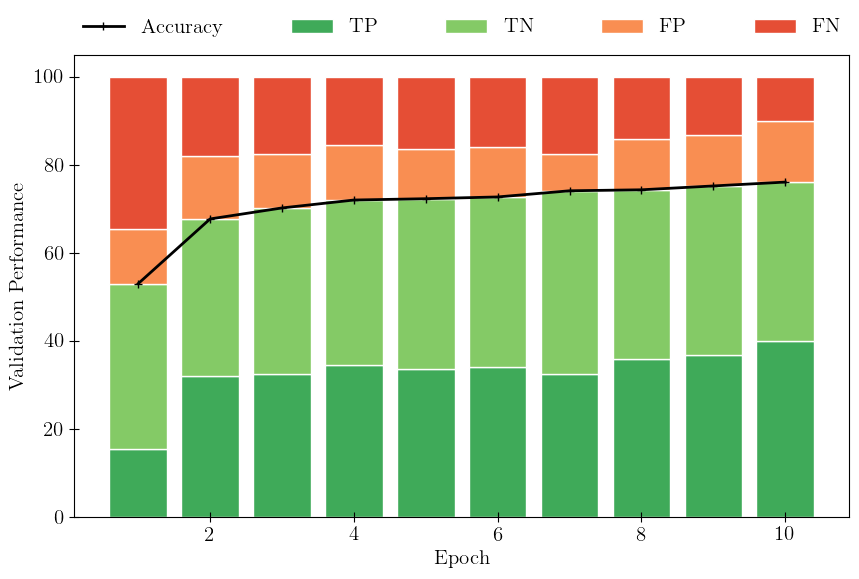

In [80]:
tp = [float(i[-1].split('|')[-1].split('%')[1].replace('', '')) for i in epochs_log]
tn = [float(i[-1].split('|')[-1].split('%')[2].replace('', '')) for i in epochs_log]
fp = [float(i[-1].split('|')[-1].split('%')[3].replace('', '')) for i in epochs_log]
fn = [float(i[-1].split('|')[-1].split('%')[4].replace('', '')) for i in epochs_log]

A = np.array(tp)
B = np.array(tn)
C = np.array(fp)
D = np.array(fn)

Total = A + B + C + D

norm_A = A / Total * 100
norm_B = B / Total * 100
norm_C = C / Total * 100
norm_D = D / Total * 100

Pos = range(1, epochs+1)

colors = plt.get_cmap('RdYlGn')(np.linspace(0.15, 0.85, 8))
# colors = ['#76AD3B', '#BAF1A1', '#FF9904', '#F44E54']
        

# plt.figure(figsize=(8,5), dpi=100)
fig, ax = plt.subplots(dpi=100)

plt.bar(Pos, norm_A, color=colors[7], edgecolor='white', label='TP')
plt.bar(Pos, norm_B, bottom = norm_A, color=colors[6], edgecolor='white', label='TN')
plt.bar(Pos, norm_C, bottom = norm_A + norm_B, color=colors[1], edgecolor='white', label='FP')
plt.bar(Pos, norm_D, bottom = norm_A + norm_B + norm_C, color=colors[0], edgecolor='white', label='FN')
plt.plot(Pos, norm_A+norm_B, color='black', label='Accuracy', marker='+', linewidth=2)

plt.xlabel('Epoch')
plt.ylabel('Validation Performance')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=5, mode="expand", borderaxespad=0., frameon=False)
     
plt.savefig('results.png', dpi=300)
plt.show()

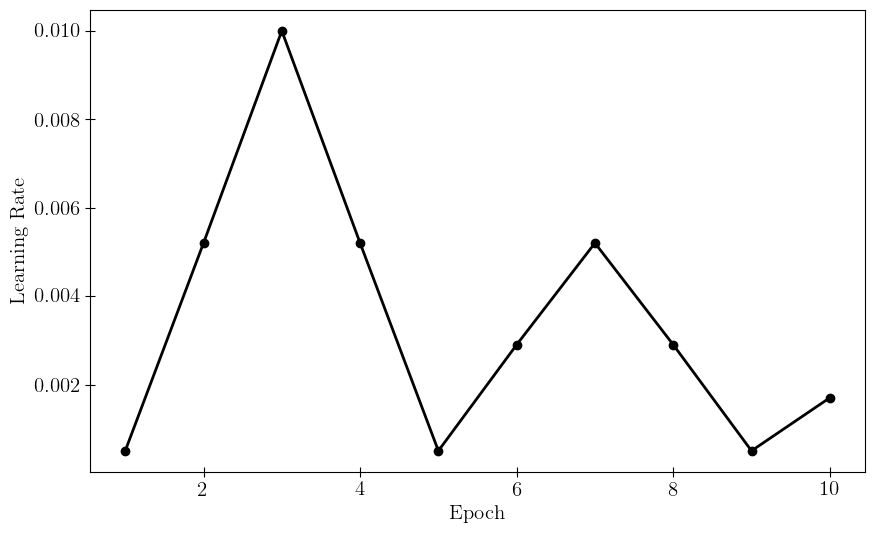

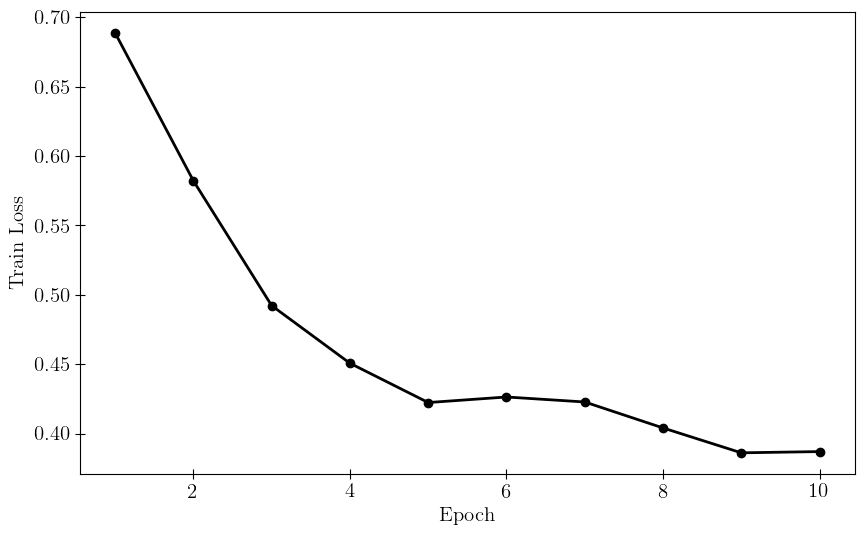

In [81]:
lr = [float(log[2].replace(' ', '')) for log in epochs_log]
train_loss = [float(log[3].replace(' ', '')) for log in epochs_log]

Pos = range(1, epochs+1)

plt.figure(dpi=100)
plt.plot(Pos, lr, color='black', label='Learning rate', marker='o', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.savefig('lr.png', dpi=300)
plt.show()

plt.figure(dpi=100)
plt.plot(Pos, train_loss, color='black', label='Learning rate', marker='o', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.savefig('train_loss.png', dpi=300)
plt.show()

## Results

> VGG

```python
    model = nn.Sequential(
        nn.Linear(4096, 8192),
        nn.ReLU(),
        nn.Linear(8192, 4096),
        nn.ReLU(),
        nn.Linear(4096, 2048),
        nn.ReLU(),
        nn.Linear(2048, 1),
        nn.Sigmoid()
    )
    criterion = nn.BCELoss()
    optimizer = torch.optim.SGD(model.parameters())
    scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=5e-5, max_lr=1e-3,step_size_up=2,mode="triangular2")
```

```
  Time   | Epoch | learning rate |  Loss  | accuracy    tp      tn      fp      fn   
---------|-------|---------------|--------|------------------------------------------
00:00:16 | 01/10 |    5.0e-05    | 0.4137 |  80.89%    42.4%   38.5%   11.5%   7.6%
00:00:32 | 02/10 |    5.2e-04    | 0.3501 |  84.06%    41.8%   42.3%   7.7%   8.2%
00:00:48 | 03/10 |    1.0e-03    | 0.2412 |  84.47%    39.7%   44.7%   5.3%   10.3%
00:01:04 | 04/10 |    5.2e-04    | 0.1306 |  84.56%    38.9%   45.6%   4.4%   11.1%
00:01:20 | 05/10 |    5.0e-05    | 0.0594 |  85.71%    41.7%   44.0%   6.0%   8.3%
00:01:36 | 06/10 |    2.9e-04    | 0.0479 |  85.45%    41.9%   43.5%   6.5%   8.1%
00:01:52 | 07/10 |    5.2e-04    | 0.0259 |  85.30%    43.5%   41.8%   8.2%   6.5%
00:02:09 | 08/10 |    2.9e-04    | 0.0105 |  85.58%    42.0%   43.5%   6.5%   8.0%
00:02:25 | 09/10 |    5.0e-05    | 0.0066 |  85.78%    41.5%   44.3%   5.7%   8.5%
00:02:41 | 10/10 |    1.7e-04    | 0.0060 |  85.75%    41.5%   44.3%   5.7%   8.5%
```


> ViT

```python
    model = nn.Sequential(
        nn.Linear(768, 8192),
        nn.ReLU(),
        nn.Linear(8192, 4096),
        nn.ReLU(),
        nn.Linear(4096, 2048),
        nn.ReLU(),
        nn.Linear(2048, 1),
        nn.Sigmoid()
    )
    criterion = nn.BCELoss()
    optimizer = torch.optim.SGD(model.parameters())
    scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=5e-4, max_lr=1e-2,step_size_up=2,mode="triangular2")
```

```
         |       |               |        |                 Validation               
  Time   | Epoch | learning rate |  Loss  | accuracy    tp      tn      fp      fn   
---------|-------|---------------|--------|------------------------------------------
00:00:10 | 01/10 |    5.0e-04    | 0.6887 |  53.07%    15.4%   37.6%   12.4%   34.6%
00:00:20 | 02/10 |    5.2e-03    | 0.5822 |  67.68%    31.9%   35.8%   14.2%   18.1%
00:00:31 | 03/10 |    1.0e-02    | 0.4923 |  70.24%    32.4%   37.8%   12.2%   17.6%
00:00:41 | 04/10 |    5.2e-03    | 0.4508 |  72.05%    34.6%   37.4%   12.6%   15.4%
00:00:51 | 05/10 |    5.0e-04    | 0.4225 |  72.31%    33.5%   38.8%   11.2%   16.5%
00:01:02 | 06/10 |    2.9e-03    | 0.4265 |  72.66%    34.0%   38.7%   11.3%   16.0%
00:01:13 | 07/10 |    5.2e-03    | 0.4229 |  74.11%    32.5%   41.6%   8.4%   17.5%
00:01:23 | 08/10 |    2.9e-03    | 0.4042 |  74.37%    35.9%   38.5%   11.6%   14.1%
00:01:34 | 09/10 |    5.0e-04    | 0.3863 |  75.15%    36.8%   38.4%   11.6%   13.2%
00:01:44 | 10/10 |    1.7e-03    | 0.3872 |  76.01%    39.9%   36.1%   13.8%   10.1%
```

# Classic ML Methods

In [6]:
from sklearn.linear_model import LogisticRegression

In [8]:
clf = LogisticRegression(random_state=0, max_iter=200)
clf.fit(train_features, train_labels)
print('Logistic Regression:')
print(f'Train score: {clf.score(train_features, train_labels)}')
print(f'Validation score: {clf.score(val_features, val_labels)}')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Logistic Regression:
Train score: 0.79015
Validation score: 0.707


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [20]:
clf = LogisticRegression(random_state=0, max_iter=200)
clf.fit(train_features_vgg, train_labels_vgg)
print('Logistic Regression:')
print(f'Train score: {clf.score(train_features_vgg, train_labels_vgg)}')
print(f'Validation score: {clf.score(val_features_vgg, val_labels_vgg)}')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Logistic Regression:
Train score: 0.9003833333333333
Validation score: 0.8482
